# Goal of the tutorial
In this tutorial we will: 
- Understand convolutions
- Build a convolutional neural network using PyTorch
- Analyse what individual layers in a convolutional neural network have learned through a data reconstruction.

# Loading the libraries and dataset

In [2]:
# Let's load the usual libraries
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size. Let's load it. 

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Implementing convolutions

Let's visualise some of the images and apply some example convolutions to them, just to see what a convolution does. Here I will use numpy's convolution operator. 

In [4]:
# get some random training images; this will load a set of images of size batchsize 
dataiter = iter(trainloader)
images, labels = next(dataiter)
img = images[0] # take just the first image; the above thing is an array of images of size batchsize
img = img / 2 + 0.5     # unnormalize

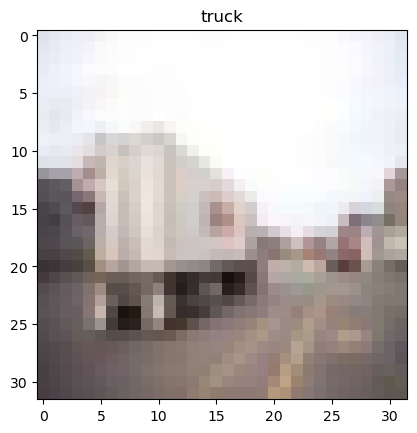

In [7]:
# Print the original image
npimg = img.numpy() # translate to numpy
npimg_t = np.transpose(npimg, (1, 2, 0))
plt.imshow(npimg_t)
plt.title(str(classes[labels[0]]))
plt.show()

Let's define our own convolution operator to be sure we understand what is happening:

In [8]:
def convolution2d(image, kernel):
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
        for i in range(y):
            for j in range(x):
                # what's going on? # we take the product of a subset of the image and the kernel and sum the terms
                new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel) 
    return new_image

In a color image, we normally have 3 channels: red, green and blue; this way, a color image can be represented as a matrix of dimensions 𝑤×ℎ×𝑐, where 𝑐 is the number of channels, that is, 3 and $w$ is the width and $h$ is the height. Our operation allows for a two-dimensional array; but (check the shape below), our image has 3 dimensions (as is standard for an image). Let us apply the filter (=convolution) to each channel individually. This is the way a neural network will do it as well - only it may use a different filter for each channel. 

(32, 32, 3)


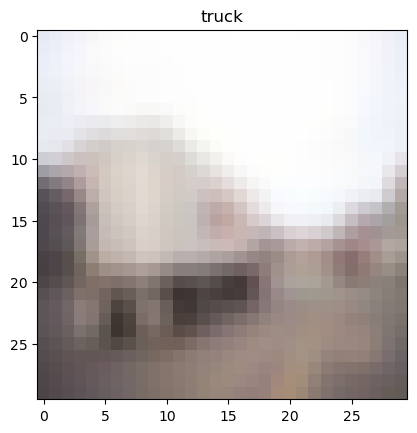

In [9]:
print(npimg_t.shape)
# Let's apply a convolution per each 'channel' of the input with a blurring kernel
K = np.array([[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111],
         [0.1111, 0.1111, 0.1111]])
npimg_conv1 = np.zeros([30,30,3])
for it in range(npimg_t.shape[2]):
    npimg_conv1[:,:,it] = convolution2d(npimg_t[:,:,it], K)
plt.imshow(npimg_conv1)
plt.title(str(classes[labels[0]]))
plt.show()

The image is blurred - as expected. One important thing to consider: we have changed the size of the output. Suppose the input image is of size WxH and the convolution kernel is KxK. Then the output will be of size (W-K+1)x(W-K+1). 

# Implementing a Convolutional Neural Network

Let's move on to implementing a convolutional neural network. We will use PyTorch for this (i.e. we won't implement the layers from scratch, although we could: just change the fully-connected layers in the previous week with convolutions). 

Let x be the input. Our network will have the following structure: 
1. The input goes into a convolutional layer with 3 input channels, 6 output channels and kernel of size 5x5 followed by a ReLU activation + pooling layer 
2. The output from the previous operation goes into another convolutional layer with 6 input channels, 16 output channels and a kernel of size 5x5 followed by a ReLU + pooling
3. Then there will be two linear layers + ReLU's and a final linear layer. 

Remember the following:

We have an input $I$ of size $[N, C_{in}, H, W]$, where $N$ is the number of images passed through the layer, $C_{in}$ is the number of channels each image has, and $H$ and $W$ are the height and width of the image, respectively. 
The output is then computed as, 
$$
O[N_n, C_{out_j}, :, :] = b[C_{out_j}] + \sum_{i=0}^{C_{in}-1} w[C_{out_j},i]*I[N_n, i, :, :].
$$

We will use PyTorch's Conv2d function to implement the convolution. It has the following arguments: 
- in_channels: the number of channels of the input
- out_channels: the number of channels we want the output to have (i.e. how many times we apply different kernels)
- kernel_size: the size of the filter

It has some other parameters of which we will use the default modes (and hence we don't specify them):
bias = True, stride = 1, padding = 0, dilation = 1. 

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    # in the init function we will just define several layers that we can later use
    def __init__(self):
        super().__init__()
        # a convolutional layer with 3 input channels, 6 output channels and kernel of size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # what is the size of the object after the above convolution? original image is 32x32; after convolution
        # it will be 32-5-1 = 28 -> 28x28
        # a pooling layer: it 'pools' together 2 of the inputs by keeping only the maximum value 
        # and uses a stride of 2
        self.pool = nn.MaxPool2d(2, stride=2)
        # after pooling size is 14x14 (see: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # here we define the forward pass, i.e. how our input x is modified as it moves through the network
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # size after operation: 14x14
        x = self.pool(F.relu(self.conv2(x))) # size after operation: (10-1)/2+1=5.5; round down to int is 5
        x = torch.flatten(x, 1) # flatten all dimensions except batch; size is 16*5*5
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Define a loss function and optimiser

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# As a remark: the CrossEntropyLoss of PyTorch directly applies the softmax to the output, 
# so no need to pass through softmax first. 

Let's train the network.

In [12]:
nr_epochs = 1 # the number of times we iterate over our dataset
losses = [] # store the losses

for epoch in range(0,nr_epochs):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # Compute the output for all the images in the batch_size; remember we set a batch_size of 4 in the beginning!
        outputs = net(images)
        # Compute the loss value
        loss = criterion(outputs, labels)
        # Compute the gradients
        loss.backward()
        # Take the optimisation step
        optimizer.step()

        # print statistics
        losses += [loss.item()]
        if i % 1000 == 0:    # print every 100 iterations
            print(i, loss.item())

print('Finished Training')

0 2.3014791011810303
1000 2.3159940242767334
2000 1.8735929727554321
3000 2.0334653854370117
4000 1.8447967767715454
Finished Training


Let us test the network on the unseen (test) data. 

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs; therefore there
# is no need to store the computational graph in between
with torch.no_grad():
    for data in testloader: #iterate over all the test images
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        # compute the total number of images processed by adding the number of images in each batch
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 41 %


# Let us try to improve the model accuracy by using a larger model. 

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    # in the init function we will just define several layers that we can later use
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3) 
        self.conv2 = nn.Conv2d(64, 128, 3) 
        self.conv3 = nn.Conv2d(128, 256, 3) 
        self.conv4 = nn.Conv2d(256, 256, 3) 
        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(1024, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # here we define the forward pass, i.e. how our input x is modified as it moves through the network
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # let's also define a method to access a layer of choice's output; we will use this later
    def forward_partial(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        return x # you can change the partial forward pass to obtain arbitrary layers' output

net = Net()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

nr_epochs = 5 # the number of times we iterate over our dataset
losses = [] # store the losses

for epoch in range(0,nr_epochs):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # Compute the output for all the images in the batch_size; remember we set a batch_size of 4 in the beginning!
        outputs = net(images)
        # Compute the loss value
        loss = criterion(outputs, labels)
        # Compute the gradients
        loss.backward()
        # Take the optimisation step
        optimizer.step()

        # print statistics
        losses += [loss.item()]
        if i % 1000 == 0:    # print every 100 iterations
            print(i, loss.item())

print('Finished Training')

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs; therefore there
# is no need to store the computational graph in between
with torch.no_grad():
    for data in testloader: #iterate over all the test images
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        # compute the total number of images processed by adding the number of images in each batch
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

0 2.3085150718688965
1000 2.3075826168060303
2000 2.196249008178711
3000 2.217001438140869
4000 1.9269192218780518
0 1.7517439126968384
1000 1.4503657817840576
2000 1.725237250328064
3000 1.5091155767440796
4000 1.7770328521728516
0 1.611853837966919
1000 1.1129494905471802
2000 1.4608269929885864
3000 1.284955620765686
4000 2.0431113243103027
0 1.3215796947479248
1000 0.663138747215271
2000 0.5688529014587402
3000 1.3120884895324707
4000 0.8482465744018555
0 0.9085317850112915
1000 0.9206363558769226
2000 0.7033025622367859
3000 0.6958565711975098
4000 0.8926868438720703
Finished Training
Accuracy of the network on the test images: 69 %


### Task: change the model
Please do change the architecture, number of batches (we defined this when we loaded the data in one of the first cells) and number of epochs to see how this changes what the network has learned. 

Remember: machine learning is quite tricky with lots of hyperparameter tuning required. A large part of the job is trying to find the right combinations of parameters that work.

### Optional: use a smaller dataset
The other thing you can change is the size of the dataset used. Now I use the full dataset, but if we only use a subset of the data we'll achieve a better train accuracy (at the cost of a worse test performance). You can do that using:

trainset_ss = torch.utils.data.Subset(trainset, list(range(0, subset))) # loads a subset

trainloader = torch.utils.data.DataLoader(trainset_ss, batch_size=batch_size,
                                          shuffle=True, num_workers=2) # plugs that subset into the dataloader

# Understanding what our network has learned

Now, we would like to understand what the network has actually learned. The work in: https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html does something similar, so check it out if you're interested. 

Consider that we pass a certain image $\tilde x$ through the network and get the output $z^n$ from the neural network. 

Based on that output we would like to reconstruct the input to better understand how well our neural network has learned the original image. Denote with $\hat z^n$ the output from the same layer for some input $x$. 

Consider then the squared error loss
$$
\mathcal{L}(z^n, \hat z^n) = ||z^n-\hat z^n||_2^2,
$$

We will give the network a certain input image $\tilde x$ and obtain the layer values for that image $z^n$. We assume we only observe $z^n$, but want to *reconstruct* $\tilde x$. To do that we will optimise over the $x$ that gets us as close as possible to that layer output: 
$$
x^* = \arg\min_{x} \mathcal{L}(z^n, \hat z^n).
$$

We will further follow the work of https://arxiv.org/pdf/1412.0035v1.pdf 

It can be useful to restrict the reconstruction to the subset of natural images - in order to make the above reconstruction better (and easier to interpret). In order to do so, we need to define the properties that natural images have. A proxy used in the above paper is to incorporate in the reconstruction an appropriate image prior. As in the paper, we will try two things: 

1. the $\alpha$-norm: $R(x) = ||x||_{\alpha}^{\alpha}$ where $x$ is the vectorised and meansubtracted image. With this regularisation we force the image values to stay within a certain range. 

2. the total variation encouraging images to consist of piece-wise constant patches: $R(x) = \sum_{i,j} \left((x_{i,j+1}-x_{ij})^2 + (x_{i+1,j}-x_{ij})^2\right)^{\frac{\beta}{2}}$ where $x\in\mathbb{R}^{H\times W}$ with $H$ the height and $W$ the width. 

We will add the above terms as regularisers to our loss function. 

In [16]:
# Define our new criteria:
def R_1(img, alpha): 
    img = torch.flatten(img)
    R1 = torch.linalg.norm(img, ord=alpha)
    return R1

def R_2(img, beta):
    R2 = torch.sum(torch.pow(torch.flatten(torch.pow(img[:,:,:,1:] - img[:,:,:,:-1], 2)) \
                                + torch.flatten(torch.pow(img[:,:,1:,:] - img[:,:,:-1,:], 2)), beta/2))
    return R2

# Load a new batch of data
dataiter = iter(trainloader)

Let us now implement the optimisation scheme. We will begin by initialising a random image, then minimising the loss criterion that we discussed above. 

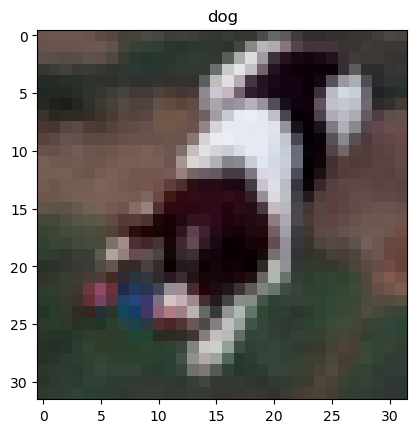

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


723.0613403320312
371.0378723144531
372.44921875
381.09454345703125
379.5087890625
383.50433349609375
383.1741027832031
366.6451416015625
385.0224304199219
384.82171630859375
386.4903869628906
383.20794677734375
375.50537109375
390.29217529296875
377.91217041015625
383.22772216796875
378.5281677246094
384.1646423339844
382.5508117675781
380.06365966796875


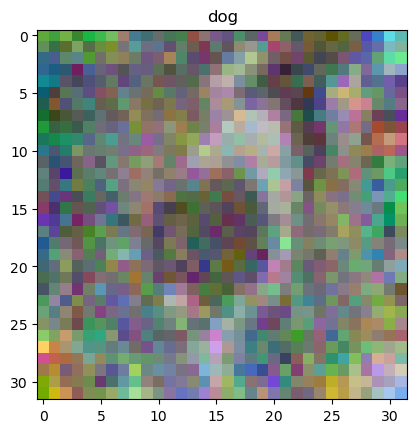

In [17]:
# Get some image
images, labels = next(dataiter)
img = images[0] # take just the first image; the above thing is an array of images of size batchsize
img = img / 2 + 0.5     # unnormalize

# Print the original image
npimg = img.numpy() # translate to numpy
npimg_t = np.transpose(npimg, (1, 2, 0)) # transpose things
plt.imshow(npimg_t)
plt.title(str(classes[labels[0]]))
plt.show()

# Pas the image through the network and get the layer output
true_out = net.forward_partial(images[0:1,:,:,:])

# Optimize the output from the layer for some random input to get close to the output for the original image
sample_image = torch.rand(1, 3, 32, 32)
sample_image.requires_grad = True 
nr_its_in = 100000
lr = 0.0001
for it in range(nr_its_in):
    sample_out = net.forward_partial(sample_image)
    sample_loss = torch.sum(torch.pow(true_out.detach() - sample_out, 2)) \
            + 0.05 * R_1(sample_image, 6) + 0.1 * R_2(sample_image, beta=2)
    sample_loss.backward()
    # Perform the gradient step to improve the sample_image
    with torch.no_grad():
        sample_image -= lr*sample_image.grad #+ 0.001*torch.rand(sample_image.shape)
    if it%5000==0:
        print(sample_loss.item())

# Print reconstructed image
numpy_image = sample_image.detach().numpy()
# Constrain to the right range
numpy_image += np.abs(numpy_image.min())
numpy_image /= numpy_image.max()
numpy_image = np.transpose(numpy_image[0,:,:,:], (1, 2, 0))
plt.imshow(numpy_image)
plt.title(classes[labels[0]])
plt.show()

Run the above code multiple times - for certain images the reconstruction works better than for others. 

#### Task: 
Try to change the layer whose output we use. You can do this by modifying the forward_partial function we defined in the neural network class. Are any particular layers better at reconstructing the image? The later the layer you choose, the worse the reconstruction typically as later layers contain more high-level information. 

Also try to add or remove the noise - is there any difference in training with noise? Try also changing the parameters to see if you can find a configuration which obtains better results than what I managed to obtain. 

What do you think of the above? We can in general reconstruct something even with our relatively simple model (compared to the architectures Google and so on use). What if the input image contained sensitive information? Can you think that the above is a privacy or security risk?

Final thing to try: suppose we are given an output class. Can we then re-compute an input image for that output class? The work in https://arxiv.org/pdf/1312.6034.pdf considers something similar. 

Suppose we optimize our cross-entropy loss between the output of the final layer and the given class label over the input. 

Chosen class is cat
105.28050994873047
53.240779876708984
49.838096618652344
54.451385498046875
50.916324615478516
51.9841194152832
53.97142791748047
55.985416412353516
53.07731246948242
52.45166778564453
53.427066802978516
51.9844970703125
52.13863754272461
51.98976516723633
55.25703048706055
54.1082878112793
54.532470703125
54.20526885986328
52.12474060058594
53.048309326171875


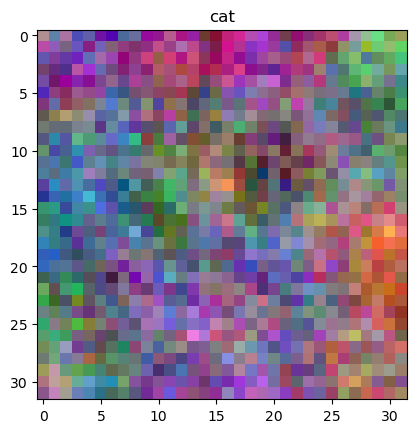

In [18]:
# Select some class of interest
class_interest = 3
print('Chosen class is ' + str(classes[class_interest]))

# Optimize the random image to get a label close to the original image
sample_image = torch.rand(1, 3, 32, 32)
sample_image.requires_grad = True 
nr_its_in = 100000
lr = 0.0001
for it in range(nr_its_in):
    sample_out = net(sample_image)
    sample_loss = criterion(sample_out, torch.tensor([class_interest])) \
            + 1 * R_1(sample_image, 6) + 0.1 * R_2(sample_image, beta=2)
    sample_loss.backward()
    # Perform the gradient step to improve the sample_image
    with torch.no_grad():
        sample_image -= lr*sample_image.grad #+ 0.001*torch.rand(sample_image.shape)
    if it%5000==0:
        print(sample_loss.item())

# Print reconstructed image
numpy_image = sample_image.detach().numpy()
# Constrain to the right range
numpy_image += np.abs(numpy_image.min())
numpy_image /= numpy_image.max()
numpy_image = np.transpose(numpy_image[0,:,:,:], (1, 2, 0))
plt.imshow(numpy_image)
plt.title(classes[class_interest])
plt.show()

Up to you to decide how useful the above is, but we do seem to see some patterns. 

#### Task
Try changing the weighting of the different terms to see if you can obtain something better than what I obtained. 